# Laboratory Work 1:

In [1]:
## Installing necessary libraries
# !pip install torch torchvision
# !pip install tqdm
# !pip install matplotlib
# !pip install numpy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

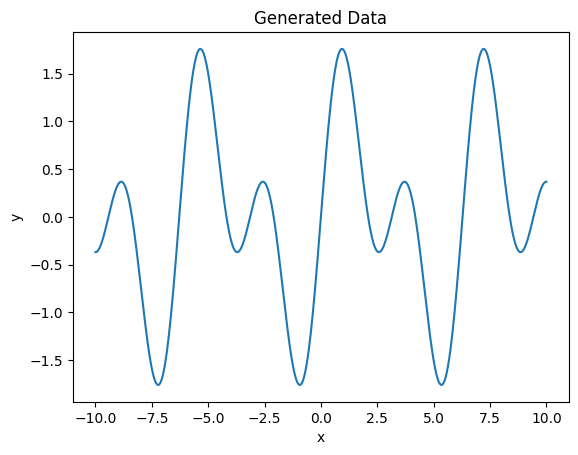

In [3]:
# generating data as per lab requirement
x = np.linspace(-10, 10, 1000)
y = np.sin(2 * x) + np.sin(x)
x = list(x)

# plotting the generated data
plt.plot(x, y)
plt.title("Generated Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Lets train a NN to approximate the above generated data using pytorch

In [4]:
# converting data to tensors
x_tensor = torch.Tensor(x).unsqueeze(1) # shape from (1000,) -> (1000, 1)
y_tensor = torch.Tensor(y).unsqueeze(1) # shape from (1000,) -> (1000, 1)

In [5]:
# creating a model by Custom class dervied from nn.Module. In constructor, we define the layers of the model.
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # stating the number of inputs and outputs for layers
        self.hidden1 = nn.Linear(1, 16) # input layer to first hidden layer has 1 input and 64 outputs
        self.hidden2 = nn.Linear(16, 128) # first hidden layer to second hidden layer has 64 inputs and 32 outputs
        self.output = nn.Linear(128, 1) # second hidden layer to output layer has 32 inputs and 1 output
        self.relu = nn.ReLU() # ReLU activation function

    def forward(self, x): # forward method defines the forward pass of the model
        x = self.relu(self.hidden1(x)) # applying ReLU activation after first hidden layer
        x = self.relu(self.hidden2(x)) # applying ReLU activation after second hidden layer
        x = self.output(x) # output layer (no activation function here)
        return x

# Instantiating the model.
model = SimpleNN()

## Insights:
##### ------------------ Case 1
- first layer: 32 outs, 
- second layer: 16 outs,
- epochs: 4000
- In the begining, the curves are triangular but the line matches. It learned well (close) at range -2.5 to 2.5. at last, it is same as begining part --> Good

##### ------------------ Case 2
Layers reduced:
- first layer: 16, second layer: 8, epochs: 4000
--> Worst

##### ------------------ Case 3
Layers INcreased:
- first layer: 128, second layer: 64, epochs: 4000 --> better output than case1

##### ------------------ Case 4
when first layer is 32/16, second layer is 64/32, epochs: 4000 --> predicted data starts to shift slightly above the actual line/data. find why?

##### ------------------ Case 5
- first layer: 16, second layer: 128, epochs: 4000 --> prediction is very close to actual data. find why? [**USING THIS**]

##### ------------------ 

1. Epochs inc., model prediction improves. 
2. Number of neurons each layer inc., model prediction shifts slightly upwards.
3. Number of neurons each layer dec., model prediction somewhat retains actual.

In [6]:
criterion = nn.MSELoss() # Mean Squared Error loss function for regression
optimizer = optim.Adam(model.parameters(), lr = 0.01) # Adam optimizer with learning rate of 0.01

In [7]:
# Training Loop
epochs = 4000 #8000 epochs -> close to original, 4000 epochs -> first wave not learned properly but further waves are learned.
losses = [] # to store loss values for plotting later

for epoch in tqdm(range(epochs)):
    model.train() # set the model to training mode

    # forward pass
    outputs = model(x_tensor) # propagate the input through the model and fetch the predicted output
    loss = criterion(outputs, y_tensor) # compute the loss between predicted and actual output
    
    # Backward pass and optimization
    optimizer.zero_grad() # clears old gradients from the last step
    loss.backward() # compute the gradient of the loss w.r.t. model parameters
    optimizer.step() # update the model parameters based on the computed gradients

    # appending the loss value to the list
    losses.append(loss.item())

    if epoch + 1 % 100 == 0: # print loss every 100 epochs
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

100%|██████████| 4000/4000 [00:14<00:00, 278.80it/s]


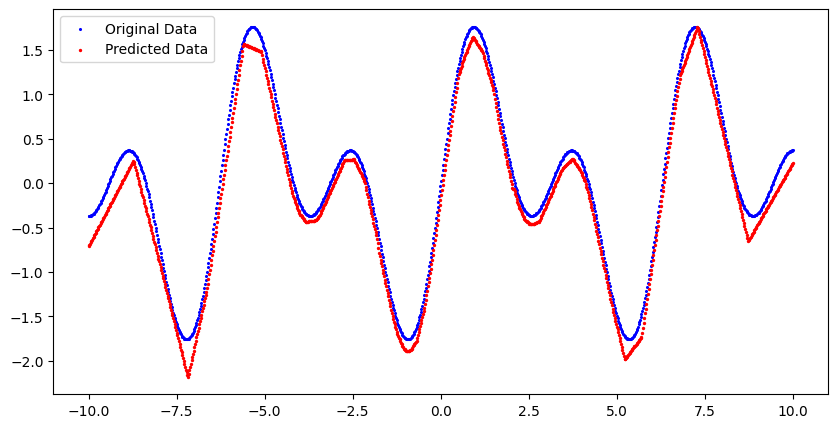

In [8]:
model.eval() # set the model to evaluation mode

with torch.no_grad(): # disable gradient calculation for inference
    predicted = model(x_tensor).detach().numpy() # calculate the predicted output, detach from the computation graph and convert to numpy array

# Plotting the results
plt.figure(figsize = (10, 5))
plt.scatter(x, y, label = "Original Data", color = "blue", s = 1.5)
plt.scatter(x, predicted, label = "Predicted Data", color = "red", s = 2)
plt.legend()
plt.show()

In [9]:
# import sys
# print("Python executable:", sys.executable)

# import numpy
# print("NumPy version:", numpy.__version__)

# import torch
# print("Torch version:", torch.__version__)


### Lets try to see if the model predicts close if the range of data points are increased

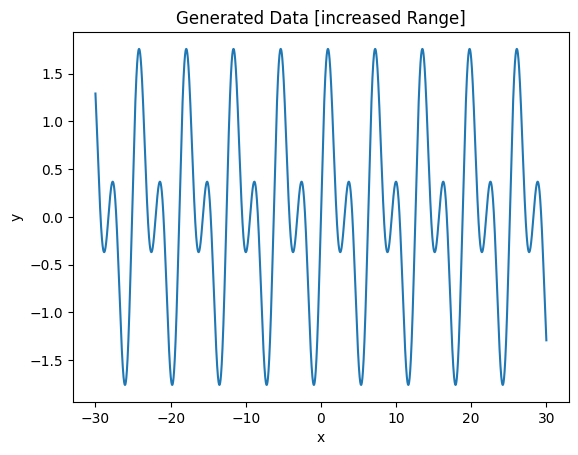

In [11]:
x = np.linspace(-30, 30, 10000)
y = np.sin(2 * x) + np.sin(x)
x = list(x)
plt.plot(x, y)
plt.title("Generated Data [increased Range]")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# convert to tensors
x_tensor = torch.Tensor(x).unsqueeze(1) 
y_tensor = torch.Tensor(y).unsqueeze(1)

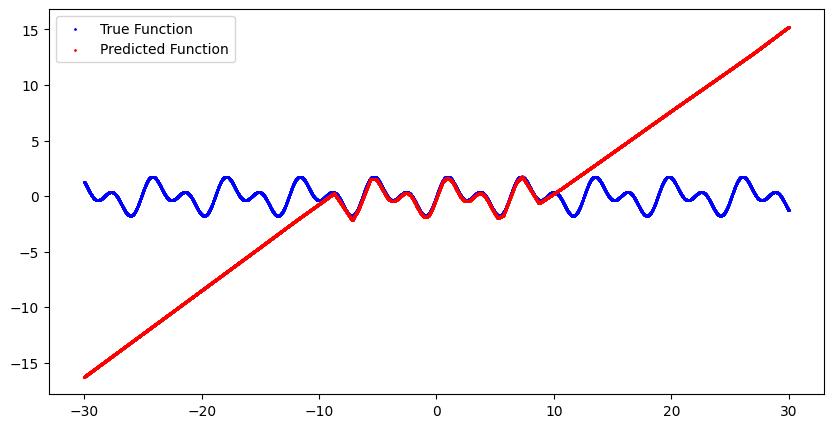

In [12]:
model.eval() # set the model to evaluation mode

with torch.no_grad():
    predicted = model(x_tensor).numpy()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

### As expected, the data approximates well for the range where it was trianed for (that is -10, 10). It is fitting worst outside that range.

# Using Batches

In [13]:
dataset = TensorDataset(x_tensor, y_tensor) # Creating a dataset object from our converted data tensors
batch_size = 16
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


In [14]:
# training Loop
epochs = 200
losses = []

for epoch in tqdm(range(epochs)):
    model.train() # set the model to training mode
    
    for batch_x, batch_y in dataloader:
        # forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

 10%|█         | 20/200 [00:31<06:10,  2.06s/it]

Epoch [20/200], Loss: 0.5954


 20%|██        | 40/200 [00:58<03:13,  1.21s/it]

Epoch [40/200], Loss: 0.1580


 30%|███       | 60/200 [01:22<02:54,  1.25s/it]

Epoch [60/200], Loss: 0.5490


 40%|████      | 80/200 [01:47<02:29,  1.25s/it]

Epoch [80/200], Loss: 1.3268


 50%|█████     | 100/200 [02:13<02:12,  1.32s/it]

Epoch [100/200], Loss: 1.0733


 60%|██████    | 120/200 [02:38<01:35,  1.19s/it]

Epoch [120/200], Loss: 0.8173


 70%|███████   | 140/200 [03:03<01:29,  1.49s/it]

Epoch [140/200], Loss: 0.9250


 80%|████████  | 160/200 [03:37<01:10,  1.77s/it]

Epoch [160/200], Loss: 0.3300


 90%|█████████ | 180/200 [04:03<00:26,  1.33s/it]

Epoch [180/200], Loss: 0.6966


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]

Epoch [200/200], Loss: 0.9284


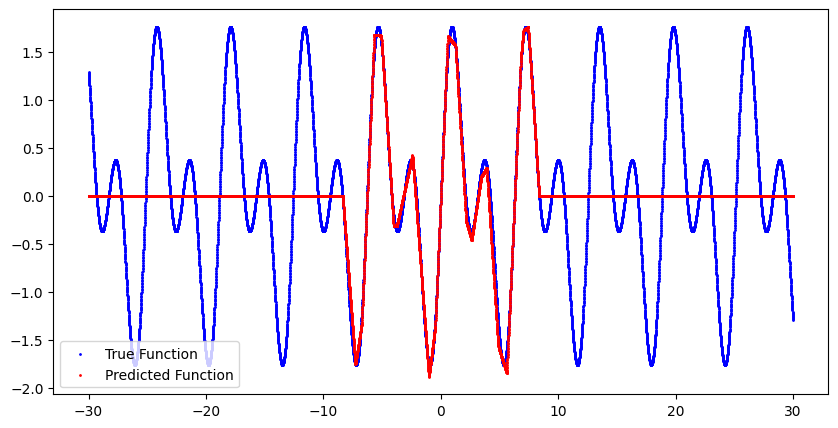

In [15]:
model.eval() # set the model to evaluation mode

with torch.no_grad():
    predicted = model(x_tensor).numpy()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

### Results are not good. Loss values initially decreased but later increased and seems oscillating.